In [1]:
import os

fname = "jena_climate_2009_2016.csv"

f = open(fname)
data= f.read()
f.close()

lines = data.split('\n')
header = lines[0]. split(',')
lines = lines[1:]

print(header)
print(len(lines))
print(lines[0])
print(lines[1])
print(lines[2])
print(type(lines[0]))



['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
<class 'str'>


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
print(float_data.shape)

for i, line in enumerate(lines):
    values = [float (x) for x in line.split(',')[1:]]
    float_data[i, :] = values

(420551, 14)


In [3]:
print(float_data[0])

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


In [4]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

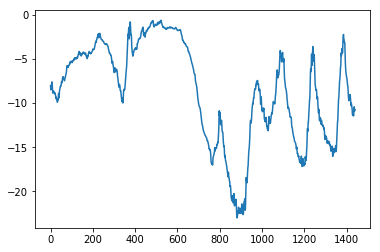

In [5]:
plt.plot(range(1440), temp[:1440])

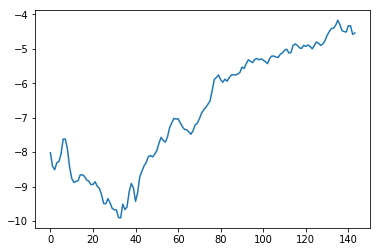

In [6]:
plt.plot(range(144), temp[:144])

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
lookback = 720 # 5 days in the past
step = 6 # 1 sample per hour
delay = 144 # target 24 h in the future
min_index = 0
max_index = 200000

def generator(
    data,
    lookback, delay,
    min_index, max_index,
    shuffle=False, # shuffle is important in the training. Validation and test can not create bias, so it's not necessary.
    batch_size=128,
    step=6):

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback # TODO redundant?
    while True:

        if shuffle:
            rows = np.random.randint(
                min_index + lookback,
                max_index,
                batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

        
g = generator(float_data, lookback, delay, min_index, max_index)
next(g)

(array([[[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
          -0.78067973, -0.27613603],
         [ 0.89778911, -1.88617347, -1.93631689, ..., -1.28265064,
          -1.26122763, -0.11218879],
         [ 0.91311851, -2.02511729, -2.07481421, ..., -1.29566585,
          -1.31700551, -0.20686255],
         ...,
         [ 0.90722258, -2.19117209, -2.23900055, ...,  0.41583332,
           0.34774971, -1.86780973],
         [ 0.96146509, -2.23861632, -2.29037859, ...,  0.38329531,
           0.07744152, -1.77059594],
         [ 1.00627412, -2.37643051, -2.42999282, ..., -0.02017597,
          -0.08131091, -2.00254665]],
 
        [[ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
          -0.88794488, -0.46317443],
         [ 0.89778911, -1.88617347, -1.93631689, ..., -1.27614304,
          -1.31700551, -0.66522209],
         [ 0.92608954, -2.02285804, -2.0736973 , ..., -1.16551382,
          -1.26122763,  0.09909533],
         ...,
         [ 0.92255199, -2.2013387

In [9]:
next(g)[1].shape

(128,)

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [11]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Flatten(
    input_shape=(lookback // step, float_data.shape[-1])))
          
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1))

model.summary()
          
model.compile(
    optimizer=optimizers.RMSprop(),
    loss="mse",
    metrics=['mae']
    
    
)
    
history = model.fit_generator(
    train_gen,
    steps_per_epoch= 500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps // 100
)

C:\Users\VPL\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 21s 41ms/step - loss: 4.7106 - mean_absolute_error: 1.2558 - val_loss: 0.3666 - val_mean_absolute_error: 0.4835
Epoch 2/20
500/500 [==============================] - 21s 41ms/step - loss: 0.9293 - mean_absolute_error: 0.6593 - val_loss: 0.3036 - val_mean_absolute_error: 0.4418
Epoch 3/20
500/500 [==============================] - 20s 40ms/step 

In [12]:
model = models.Sequential()
model.add(layers.GRU(
    32,
    input_shape = (None, float_data.shape[-1])
    
))

model.add(layers.Dense(1))

          
model.compile(
    optimizer=optimizers.RMSprop(),
    loss="mse",
    metrics=['mae']
    
    
)
    
history = model.fit_generator(
    train_gen,
    steps_per_epoch= 500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps // 100
)

Epoch 1/20
500/500 [==============================] - 142s 285ms/step - loss: 0.1527 - mean_absolute_error: 0.3047 - val_loss: 0.1234 - val_mean_absolute_error: 0.2730
Epoch 2/20
500/500 [==============================] - 142s 284ms/step - loss: 0.1310 - mean_absolute_error: 0.2826 - val_loss: 0.1135 - val_mean_absolute_error: 0.2627
Epoch 3/20
500/500 [==============================] - 133s 267ms/step - loss: 0.1263 - mean_absolute_error: 0.2783 - val_loss: 0.1168 - val_mean_absolute_error: 0.2652
Epoch 4/20
500/500 [==============================] - 130s 259ms/step - loss: 0.1229 - mean_absolute_error: 0.2744 - val_loss: 0.1170 - val_mean_absolute_error: 0.2649
Epoch 5/20
500/500 [==============================] - 125s 251ms/step - loss: 0.1181 - mean_absolute_error: 0.2692 - val_loss: 0.1220 - val_mean_absolute_error: 0.2707
Epoch 6/20
418/500 [========================>.....] - ETA: 13s - loss: 0.1140 - mean_absolute_error: 0.2650

KeyboardInterrupt: 